# Data-Analysis

Import and analyze data

In [236]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [112]:
%%time
prep_path = 'data/TreehouseCompendiumSamples_LibraryPrep.tsv'
prep_df = pd.read_csv(prep_path, sep='\t', index_col=0)

CPU times: user 24 ms, sys: 4 ms, total: 28 ms
Wall time: 26.1 ms


In [3]:
%%time
corr_path = 'data/v5_all_by_all.2018-02-04.tsv'
corr_df = pd.read_csv(corr_path, sep='\t', index_col=0)

CPU times: user 2min 26s, sys: 22.4 s, total: 2min 48s
Wall time: 2min 49s


In [116]:
%%time
meta_path = 'data/clinical.tsv'
meta_df = pd.read_csv(meta_path, sep='\t', index_col=0)

CPU times: user 132 ms, sys: 0 ns, total: 132 ms
Wall time: 129 ms


In [172]:
%%time
type_path = 'data/DiseaseAnnotations_2018-04_Labels.csv'
type_df = pd.read_csv(type_path, sep=',', index_col=1)

CPU times: user 172 ms, sys: 180 ms, total: 352 ms
Wall time: 262 ms


In [10]:
print(prep_df['libSelType'].value_counts())
print('NA', len(prep_df['libSelType']) - prep_df['libSelType'].count())

polyASelection            11505
riboDepletion               191
presumed riboDepletion       32
unknown                       9
exomeSelection                8
Name: libSelType, dtype: int64
NA 1003


In [51]:
print(len(prep_df), len(meta_df), len(corr_df))

12748 11340 11340


### [?] Duplicate Entries in library prep tsv

In [61]:
prep_df.loc['TCGA-AB-2860-03']

,UMENDcount,libSelType
THid,,
TCGA-AB-2860-03,NaN,polyASelection
TCGA-AB-2860-03,NaN,NaN


In [76]:
print(sum(prep_df.index.duplicated()))
print(sum(prep_df.index.duplicated(False)))
assert 1666 == 2 * 833

833
1666


There are 833 rows which are duplicated exactly once in the prep tsv.

### Method to get correlations from TSV or JSON

In [222]:
def get_correlations(sample):
    if sample in corr_df.index:
        corr_row = corr_df.loc[sample]
        corr_dict = {s: c for s, c in zip(corr_df.index, corr_row)}
    else:
        json_path = '/data/archive/downstream/%s/tertiary/treehouse-8.0.1_comp-v5/2.0.json' % sample
        if os.path.isfile(json_path):
            with open(json_path, 'r') as f:
                corr_dict = json.loads(f.read())['correlations_vs_focus_sample']
        else:
            corr_dict = None
    return corr_dict

In [207]:
def get_samples(prefix):
    base_path = '/data/archive/downstream/'
    if prefix[:6] == 'TARGET':
        samples = [prefix+'-01A-01R']
    elif prefix[:2] == 'TH':
        prefix_path = '%s_S' % prefix
        samples = []
        for i in range(100):
            index = '%02d' % i
            sample_path = prefix_path+index
            if os.path.isdir(base_path+sample_path):
                samples.append(sample_path)
    else:
        raise Exception('Unknown prefix type')
    return samples

# Experiments/Results

In [169]:
sample_A = 'TH01_0121_S01'
sample_B = 'TH01_0123_S01'

# 1.

Recheck results: are most similar samples still AML in v5?

### TH01_0121_S01

https://jupyter.treehouse.gi.ucsc.edu/user/kellerjordan/files/TURG-Research/data/TH01_0121_S01/Summary.html

Of `6` most correlated samples, `3/6 = 0.5` were AML.

### TH01_0123_S01

https://jupyter.treehouse.gi.ucsc.edu/user/kellerjordan/files/TURG-Research/data/TH01_0123_S01/Summary.html

Of `6` most correlated samples, `6/6 = 1.0` were AML.

# 2.

For each, what fraction of top 95% (corr > 0.87) were AML?

In [228]:
def top_samples(sample, top_95=0.87):
    correlations = get_correlations(sample)
    if correlations is None:
        return []
    top_samples = []
    for s, c in correlations.items():
        if c > top_95:
            top_samples.append(s)
    return top_samples

def get_prefix(sample):
    last_pos = max(sample.rfind('_'), sample.rfind('-'))
    return sample[:last_pos]

def get_prefixes(samples):
    return [get_prefix(s) for s in samples]

def top_diseases(sample):
    corr_samples = top_samples(sample)
    prefix_corr_samples = get_prefixes(corr_samples)
    corr_diseases = type_df.loc[prefix_corr_samples]['Diagnosis/Disease']
    return corr_diseases

def fraction_aml(sample, aml='acute myeloid leukemia'):
    corr_diseases = top_diseases(sample)
    disease_counts = corr_diseases.value_counts()
    if aml in disease_counts:
        return disease_counts['acute myeloid leukemia'] / len(corr_diseases)
    else:
        return 0

In [229]:
print('%s:' % sample_A)
print(top_diseases(sample_A).value_counts())
print('Fraction AML:', fraction_aml(sample_A))
print()
print('%s:' % sample_B)
print(top_diseases(sample_B).value_counts())
print('Fraction AML:', fraction_aml(sample_B))

TH01_0121_S01:
acute myeloid leukemia              29
acute leukemia                       4
acute lymphoblastic leukemia         4
juvenile myelomonocytic leukemia     2
Name: Diagnosis/Disease, dtype: int64
Fraction AML: 0.74358974359

TH01_0123_S01:
acute myeloid leukemia          62
acute lymphoblastic leukemia    40
acute leukemia                   3
Name: Diagnosis/Disease, dtype: int64
Fraction AML: 0.590476190476


In [187]:
type_df.loc[get_prefixes(top_samples(sample_A))]

,TH Unique Donor Key,Diagnosis/Disease,Diagnostic group,Histology
Treehouse Donor ID,,,,
TCGA-AB-2860,TCGA-AB-2860,acute myeloid leukemia,Hematopoietic,NaN
TARGET-20-PARSHM,TARGET-20-PARSHM,acute myeloid leukemia,Hematopoietic,NaN
TCGA-AB-2891,TCGA-AB-2891,acute myeloid leukemia,Hematopoietic,NaN
THR08_0178,178,acute lymphoblastic leukemia,Hematopoietic,early pre-B
TCGA-AB-2882,TCGA-AB-2882,acute myeloid leukemia,Hematopoietic,NaN
TCGA-AB-2915,TCGA-AB-2915,acute myeloid leukemia,Hematopoietic,NaN
TH26_0657,657,acute leukemia,Hematopoietic,NaN
TCGA-AB-2881,TCGA-AB-2881,acute myeloid leukemia,Hematopoietic,NaN
TCGA-AB-2837,TCGA-AB-2837,acute myeloid leukemia,Hematopoietic,NaN


# 3.

Are the top most correlated samples still places in the AML cluster on tumormap?

https://tumormap.ucsc.edu/?p=CKCC/v5&node=TH26_0657_S04,TH26_0657_S05,TH26_0657_S03,TCGA-AB-2915-03,TCGA-AB-2868-03,TCGA-AB-2952-03&x=24,25,24,346,346,344&y=323,321,322,40,42,40


https://tumormap.ucsc.edu/?p=CKCC/v5&node=TCGA-AB-2934-03,TCGA-AB-2890-03,TCGA-AB-2927-03,TCGA-AB-2936-03,TCGA-AB-2915-03,TCGA-AB-2868-03&x=340,349,350,349,346,346&y=44,43,44,48,40,42

For the top six most correlated samples in each case, all that were labeled AML are placed in the AML cluster. Those that are labeled ALL are not.

# 4.

How correlated are other ALL samples with AML? Specifically, what impact does RiboD preparation have on their correlation? Use the `type_df` to find ALL samples of interest.

This section is the only one where preparation type matters, as in every other case I search only in the correlation matrix which contains only PolyA-prepared samples.

In [213]:
ALL_rows = type_df.loc[type_df['Diagnosis/Disease'] == 'acute lymphoblastic leukemia']
ALL_prefixes = list(ALL_rows.index)
len(ALL_prefixes)

238

In [215]:
ALL_samples = []
for prefix in ALL_rows.index:
    ALL_samples.extend(get_samples(prefix))
len(ALL_samples)

246

In [251]:
sources = ['THR', 'TH0', 'TARGET']

In [248]:
fracs_aml = {}
for sample in ALL_samples:
    fracs_aml[sample] = fraction_aml(sample)
fracs_aml_by_src = {}
for src in sources:
    fracs_aml_by_src[src] = [v for k, v in fracs_aml.items() if k[:len(src)] == src]

Number of samples with prefix THR: 66


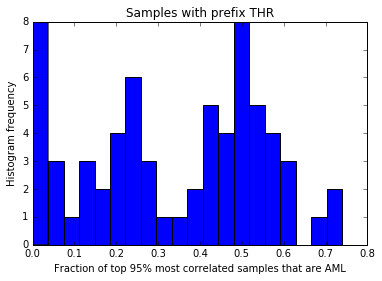

Number of samples with prefix TH0: 31


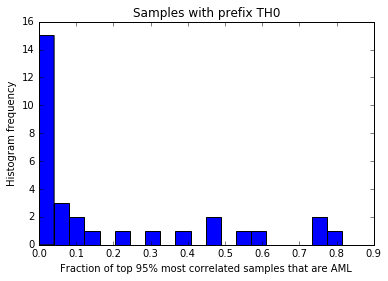

Number of samples with prefix TARGET: 149


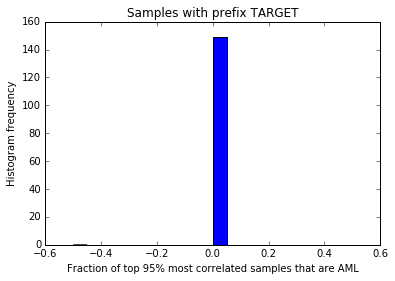

In [255]:
for src in sources:
    print('Number of samples with prefix %s:' % src, len(fracs_aml_by_src[src]))
    plt.hist(fracs_aml_by_src[src], bins=20)
    plt.title('Samples with prefix %s' % src)
    plt.xlabel('Fraction of top 95% most correlated samples that are AML')
    plt.ylabel('Histogram frequency')
    plt.show()

# 5.

Find the samples of any type that are most correlated with AML (but not AML themselves).